In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now()}')

Päivitetty 2022-02-01 11:34:36.861076


# Luottokorttipetokset

Data löytyy lähteestä: https://www.kaggle.com/mlg-ulb/creditcardfraud

Datassa ei ole alkuperäisiä selittäviä muuttujia, vaan niistä pääkomponenttianalyysilla muodostetut uudet muuttujat (sekä tietosuojan että tilastotieteellisten syiden takia). **Class**-muuttuja on ennustettava muuttuja (0 = 'ei petos', 1 = 'petos').

Petoksia on vähän suhteessa kaikkiin luottokorttitapahtumiin. Tämän vuoksi data on syytä tasapainottaa.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train_test_split osaa jakaa datan opetusdataan ja testidataan
from sklearn.model_selection import train_test_split

# Käytettävät mallit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Mallien hyvyyden arviointiin
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Tätä tarvitaan vanhemmissa versioissa:
#from sklearn.metrics import plot_confusion_matrix

# Päätöspuun piirtämiseen
from sklearn.tree import plot_tree

## Datan tarkastelua ja tasapainottaminen

In [3]:
df = pd.read_csv('creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Selitettävän/ennustettavan muuttujan jakauma on epätasapainoinen.

Tasapainotetaan data ottamalla mukaan vain 738 (1.5 * 492) henkilön satunnaisotos isommasta ryhmästä.

In [5]:
df_tasap = df[df['Class'] == 1].append(df[df['Class'] == 0].sample(n = 738, random_state = 2), ignore_index = True)
df_tasap['Class'].value_counts()

0    738
1    492
Name: Class, dtype: int64

## Mallien sovittaminen

In [6]:
# Selittävät muuttujat
X = df_tasap.drop('Class', axis = 1)

# Selitettävä/ennustettava muuttuja
y = df_tasap['Class']

# Jako opetus- ja testidataan
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

In [7]:
# Mallien sovitus

malli1 = LogisticRegression()
malli1.fit(X_train, y_train)

malli2 = DecisionTreeClassifier(max_depth = 3, random_state = 2)
malli2.fit(X_train, y_train)

malli3 = RandomForestClassifier(max_depth = 4, random_state = 2)
malli3.fit(X_train, y_train)

malli4 = GradientBoostingClassifier(max_depth = 2, random_state = 2)
malli4.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, random_state=2)

## Mallien arviointia

In [8]:
# Mallien antamat ennusteet opetus- ja testidatalle

y_train_malli1 = malli1.predict(X_train)
y_test_malli1 = malli1.predict(X_test)

y_train_malli2 = malli2.predict(X_train)
y_test_malli2 = malli2.predict(X_test)

y_train_malli3 = malli3.predict(X_train)
y_test_malli3 = malli3.predict(X_test)

y_train_malli4 = malli4.predict(X_train)
y_test_malli4 = malli4.predict(X_test)

# Oikeaan osuneiden ennusteiden osuus opetusdatassa
print('Ennusteiden tarkkuus opetusdatassa:')
print(f'Logistinen regressio {accuracy_score(y_train, y_train_malli1):.3f}')
print(f'Päätöspuu {accuracy_score(y_train, y_train_malli2):.3f}')
print(f'Satunnaismetsä {accuracy_score(y_train, y_train_malli3):.3f}')
print(f'GradientBoosting {accuracy_score(y_train, y_train_malli4):.3f}')

Ennusteiden tarkkuus opetusdatassa:
Logistinen regressio 0.946
Päätöspuu 0.946
Satunnaismetsä 0.946
GradientBoosting 0.975


In [9]:
# Oikeaan osuneiden ennusteiden osuus testidatassa
print(f'Logistinen regressio {accuracy_score(y_test, y_test_malli1):.3f}')
print(f'Päätöspuu {accuracy_score(y_test, y_test_malli2):.3f}')
print(f'Satunnaismetsä {accuracy_score(y_test, y_test_malli3):.3f}')
print(f'GradientBoosting {accuracy_score(y_test, y_test_malli4):.3f}')

Logistinen regressio 0.951
Päätöspuu 0.935
Satunnaismetsä 0.948
GradientBoosting 0.961


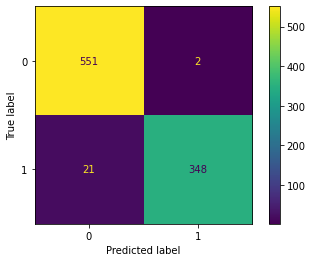

In [10]:
cm = confusion_matrix(y_train, y_train_malli4)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli4, X_train, y_train)

Opetusdatassa gradientboosting ennustaa kaksi ok-tapahtumaa petokseksi ja jättää tunnistamatta 21 petosta.

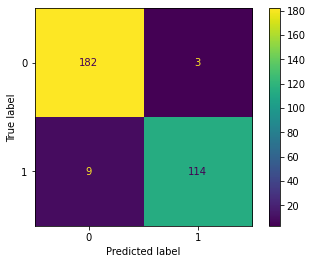

In [11]:
cm = confusion_matrix(y_test, y_test_malli4)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli4, X_test, y_test)

Testidatassa gradientboosting ennustaa kolme ok-tapahtumaa petokseksi ja jättää tunnistamatta yhdeksän petosta.

In [12]:
# Tarkastellaan vielä mallien toimivuutta alkuperäisessä datassa
X_all = df.drop('Class', axis=1)
y_all = df['Class']

In [13]:
# Satunnaismetsän ennusteet
y_all_malli1 = malli1.predict(X_all)
y_all_malli2 = malli2.predict(X_all)
y_all_malli3 = malli3.predict(X_all)
y_all_malli4 = malli4.predict(X_all)

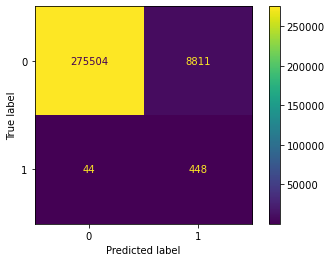

In [14]:
cm = confusion_matrix(y_all, y_all_malli1)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli1, X_all, y_all)

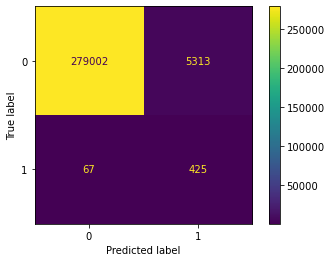

In [15]:
cm = confusion_matrix(y_all, y_all_malli2)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli2, X_all, y_all)

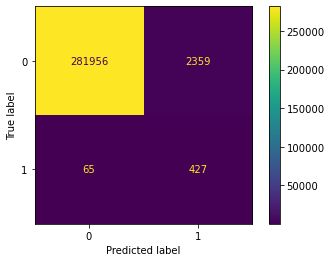

In [16]:
cm = confusion_matrix(y_all, y_all_malli3)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli3, X_all, y_all)

Jos tarkastellaan tasapainotetun datan sijasta alkuperäistä dataa, niin satunnaismetsä tuottaa vähiten virheellisiä positiivisia (2359 kpl).

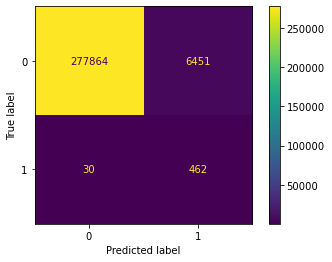

In [17]:
cm = confusion_matrix(y_all, y_all_malli4)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Seuraava toimii vanhemmissa versioissa
#plot_confusion_matrix(malli4, X_all, y_all)

Jos tarkastellaan tasapainotetun datan sijasta alkuperäistä dataa, niin GradientBoosting tunnistaa eniten petoksia (462 kpl).

[Text(236.07692307692307, 285.39000000000004, 'V14 <= -2.691\ngini = 0.48\nsamples = 922\nvalue = [553, 369]'),
 Text(85.84615384615384, 203.85000000000002, 'V14 <= -3.074\ngini = 0.006\nsamples = 309\nvalue = [1, 308]'),
 Text(42.92307692307692, 122.31, 'gini = 0.0\nsamples = 302\nvalue = [0, 302]'),
 Text(128.76923076923077, 122.31, 'V18 <= 1.963\ngini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(85.84615384615384, 40.76999999999998, 'gini = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(171.69230769230768, 40.76999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(386.30769230769226, 203.85000000000002, 'V4 <= 2.235\ngini = 0.179\nsamples = 613\nvalue = [552, 61]'),
 Text(300.46153846153845, 122.31, 'V14 <= -0.813\ngini = 0.116\nsamples = 548\nvalue = [514, 34]'),
 Text(257.53846153846155, 40.76999999999998, 'gini = 0.358\nsamples = 77\nvalue = [59, 18]'),
 Text(343.38461538461536, 40.76999999999998, 'gini = 0.066\nsamples = 471\nvalue = [455, 16]'),
 Text(472.15384615384613, 

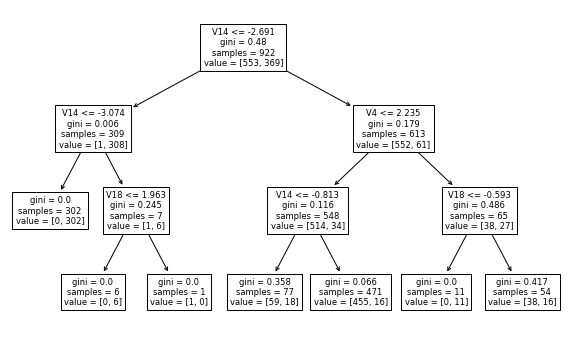

In [18]:
# Päätöspuumallin voin havainnollistaa kaaviona
plt.figure(figsize = (10, 6))
plot_tree(decision_tree = malli2, feature_names = X.columns)